# Optimizing a data center operation

## Problem Overview

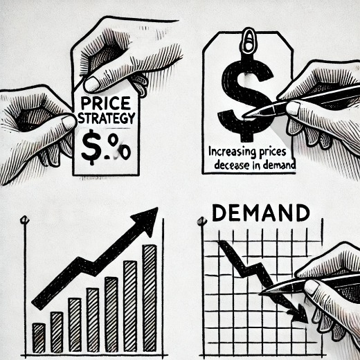

In [12]:
from PIL import Image
import requests
from io import BytesIO

img = Image.open(BytesIO(requests.get('https://github.com/Tayerquach/data_center_operations/blob/master/photo/price_strategy.jpg?raw=true').content))
resized_img = img.resize((360,360))
resized_img


**Data center operation management** is a combination of complex and challenging tasks.

In this scenario, there is one decision-maker responsible for managing four data centers. Each data center can contain two types of servers: CPU servers and GPU servers. The decision-maker’s goal is to maximize profit while adhering to a key constraint: each data center has a fixed slot capacity. To achieve this goal, the decision-maker can take five actions at each discrete time-step: buy a server, move a server from one data-center to another, hold a server as it is, dismiss a server, and set the price for any segment of demand.

For more infomarion about data center, servers, demand, please refer to the first part of this optimisation problem at [data center operation optimisation - part 1](https://github.com/Tayerquach/data_center_operations/blob/master/Data_center_operation_part1.ipynb).

In this part, we will introduce the new action "price strategy" and its related information.
Price elasticity theory was once the haunt of classical economists, with loose applications in the real world. Today, many logistics companies, with their sheer volume of data and surge algorithms, are able to continuously triangulate price elasticities in real time to manipulate demand, moment-to-moment.

In order to understand more about this price elasticity, we back in understanding demand. Both theoretical economists and business people alike represent and measure demand using the [demand curve](https://github.com/Tayerquach/data_center_operations/blob/master/photo/demand_curve.png), which is formally defined as the graphical representation of the relationship between price and the quantity demanded at any given point in time.

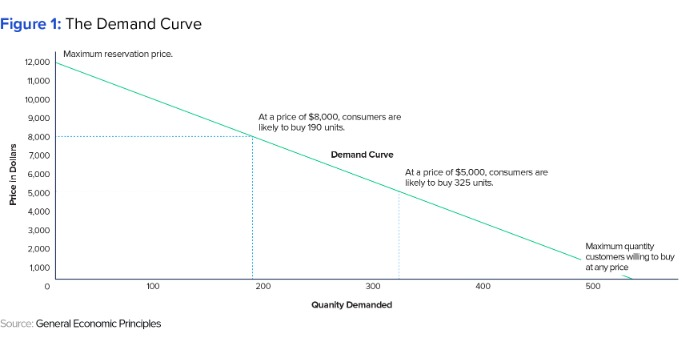

In [13]:
img = Image.open(BytesIO(requests.get('https://github.com/Tayerquach/data_center_operations/blob/master/photo/demand_curve_theory.jpg?raw=true').content))
img


The **law of demand** states that the quantity demanded of a given good/service has an inverse relationship to its price. In other words, that higher prices lead to lower quantities demanded, and vice versa.

The price elasticity of demand (PED) measures the percentage change in quantity demanded by consumers as a result of a percentage change in price. This measurement of price elasticity of demand is calculated by dividing the % change in quantity demanded by the % change in price, represented in the PED ratio.

\begin{align}
   \epsilon = \frac{\text{\% change in quantity demanded}}{\text{\% change in price}} 
\end{align}

Where $\epsilon$ is Price Elasticity of Demand

For instance, given $\epsilon$ = −2 a price increase of 10% causes a 20% decrease in quantity demanded. In practice, when a new price is set the demand is updated through the “update_demand_according_to_prices” function provided in the **Necessary functions**.


## Necessary functions

Import necessary packages needed to process the data

In [14]:
import pandas as pd
import numpy as np
from scipy.stats import truncweibull_min
from tqdm import tqdm
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [15]:
def update_selling_prices(selling_prices, ts_prices):
    # UPDATE THE SELLING PRICES ACCORDING TO THE PRICING STRATEGY
    if ts_prices.empty:
        return selling_prices
    else:
        selling_prices.update(ts_prices)
        return selling_prices


def update_demand_according_to_prices(D, selling_prices, base_prices, elasticity):
    # UPDATE THE DEMAND ACCORDING TO THE NEW PRICES
    new_prices = selling_prices.ne(base_prices)
    ix = new_prices.where(selling_prices.ne(base_prices)).stack().index.tolist()
    if ix:
        SG = D.index.values
        for sg, ls in ix:
            if sg in SG:
                d0 = D.loc[sg, ls]
                p0 = base_prices.loc[sg, ls]
                p1 = selling_prices.loc[sg, ls]
                e = elasticity.loc[sg, ls]
                d1 = get_new_demand_for_new_price(d0, p0, p1, e)
                D.loc[sg, ls] = d1
    return D


def get_new_demand_for_new_price(d0, p0, p1, e):
    # CALCULATE THE NEW DEMAND ACCORDING TO THE NEW PRICE
    delta_p = (p1 - p0) / p0
    delta_p_e = delta_p * e
    d1 = d0 * (1 + delta_p_e)

    return d1

In [16]:
def get_known(key):
    # STORE SOME CONFIGURATION VARIABLES
    if key == 'datacenter_id':
        return ['DC1',
                'DC2',
                'DC3',
                'DC4']
    elif key == 'actions':
        return ['buy',
                'hold',
                'move',
                'dismiss']
    elif key == 'server_generation':
        return ['CPU.S1',
                'CPU.S2',
                'CPU.S3',
                'CPU.S4',
                'GPU.S1',
                'GPU.S2',
                'GPU.S3']
    elif key == 'latency_sensitivity':
        return ['high',
                'medium',
                'low']
    elif key == 'required_columns':
        return ['time_step',
                'datacenter_id',
                'server_generation',
                'server_id',
                'action']
    elif key == 'time_steps':
        return 168
    elif key == 'datacenter_fields':
        return ['datacenter_id',
                'cost_of_energy',
                'latency_sensitivity',
                'slots_capacity']

In [17]:
def get_random_walk(n, mu, sigma):
    # HELPER FUNCTION TO GET A RANDOM WALK TO CHANGE THE DEMAND PATTERN
    r = np.random.normal(mu, sigma, n)
    ts = np.empty(n)
    ts[0] = r[0]
    for i in range(1, n):
        ts[i] = ts[i - 1] + r[i]
    ts = (2 * (ts - ts.min()) / np.ptp(ts)) - 1
    return ts

In [18]:
def get_actual_demand(demand):
    # CALCULATE THE ACTUAL DEMAND AT TIME-STEP t
    actual_demand = []
    for ls in get_known('latency_sensitivity'):
        for sg in get_known('server_generation'):
            d = demand[demand['latency_sensitivity'] == ls]
            sg_demand = d[sg].values.astype(float)
            rw = get_random_walk(sg_demand.shape[0], 0, 2)
            sg_demand += (rw * sg_demand)

            ls_sg_demand = pd.DataFrame()
            ls_sg_demand['time_step'] = d['time_step']
            ls_sg_demand['server_generation'] = sg
            ls_sg_demand['latency_sensitivity'] = ls
            ls_sg_demand['demand'] = sg_demand.astype(int)
            actual_demand.append(ls_sg_demand)

    actual_demand = pd.concat(actual_demand, axis=0, ignore_index=True)
    actual_demand = actual_demand.pivot(index=['time_step', 'server_generation'], columns='latency_sensitivity')
    actual_demand.columns = actual_demand.columns.droplevel(0)
    actual_demand = actual_demand.loc[actual_demand[get_known('latency_sensitivity')].sum(axis=1) > 0]
    actual_demand = actual_demand.reset_index(['time_step', 'server_generation'], col_level=1, inplace=False)
    return actual_demand

In [19]:
def load_problem_data(path=None):
    # LOAD DEMAND
    demand_path = 'https://github.com/Tayerquach/data_center_operations/blob/master/data/demand.csv?raw=true'
    demand = pd.read_csv(demand_path)

    # LOAD DATACENTERS DATA
    datacenters_path = 'https://github.com/Tayerquach/data_center_operations/blob/master/data/datacenters.csv?raw=true'
    datacenters = pd.read_csv(datacenters_path)

    # LOAD SERVERS DATA
    servers_path = 'https://github.com/Tayerquach/data_center_operations/blob/master/data/servers.csv?raw=true'
    servers = pd.read_csv(servers_path)

    # LOAD SELLING PRICES DATA
    selling_prices_path = 'https://github.com/Tayerquach/data_center_operations/blob/master/data/selling_prices.csv?raw=true'
    selling_prices = pd.read_csv(selling_prices_path)

    # LOAD ELASTICITY DATA
    elasticity_path = 'https://github.com/Tayerquach/data_center_operations/blob/master/data/price_elasticity_of_demand.csv?raw=true'
    elasticity = pd.read_csv(elasticity_path)

    return demand, datacenters, servers, selling_prices, elasticity

In [20]:
def get_maintenance_cost(b, x=1, xhat=96):
    # CALCULATE THE CURRENT MAINTENANCE COST
    return int(b * (1 + (((1.5)*(x))/xhat * np.log2(((1.5)*(x))/xhat))))

In [21]:
# Define the failure rate function
def adjust_capacity_by_failure_rate(x):
    # Calculate the failure rate f using a truncated Weibull distribution
    failure_rate = truncweibull_min.rvs(0.3, 0.05, 0.1, size=1).item()
    # Adjust capacity by the failure rate
    return x * (1 - failure_rate)

In [22]:
def load_wsl_lic(lic_path='gurobi.lic'):
    # Initialize an empty dictionary to hold the key-value pairs
    license_dict = {}
    with open(lic_path, 'r') as file:
        for line in file:
            # Strip any leading/trailing whitespace (including newline characters)
            line = line.strip()
            # Split the line into key and value
            if '=' in line:
                key, value = line.split('=', 1)  # Split on the first '='
                # Convert LICENSEID to an integer
                if key == 'LICENSEID':
                    license_dict[key] = int(value)
                else:
                    license_dict[key] = value
    return license_dict

## Data Exploration

Import necessary packages needed to visualise the data

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

### Price information



| **Column Name**        | **Description**                                                                                     |
|------------------------|-----------------------------------------------------------------------------------------------------|
| `server_generation`    | This is the unique ID of a generation of servers. There are four generations of CPU servers, and three generations of GPU servers.                                                                      |
| `latency_sensitivity`  | This is the time it takes for data to travel from its source to the data-center and back. Latency sensitivity is divided into three categories: low, medium, and high.                    |
| `elasticity`           | The relative responsiveness of the change in quantity demanded (Q) to any given change in unit price (P)   |


In [24]:
elasticity = pd.read_csv('https://github.com/Tayerquach/data_center_operations/blob/master/data/price_elasticity_of_demand.csv?raw=true')
elasticity

,server_generation,latency_sensitivity,elasticity
0,CPU.S1,low,-1.033827
1,CPU.S2,low,-1.699802
2,CPU.S3,low,-1.432123
3,CPU.S4,low,-1.929676
4,GPU.S1,low,-1.284143
5,GPU.S2,low,-1.126775
6,GPU.S3,low,-1.217129
7,CPU.S1,medium,-1.255172
8,CPU.S2,medium,-1.455615
9,CPU.S3,medium,-2.225752


**Insights:**
- **CPU vs. GPU**: Across all latency sensitivities, CPU generations tend to have higher (more negative) elasticity values compared to GPUs, meaning customers are more price-sensitive when it comes to CPU usage.
- **Latency Sensitivity**: Elasticity increases (becomes more negative) as latency sensitivity moves from low to high.


In [29]:
selling_prices = pd.read_csv('https://github.com/Tayerquach/data_center_operations/blob/master/data/selling_prices.csv?raw=true')
selling_prices

,server_generation,latency_sensitivity,selling_price
0,CPU.S1,low,10.0
1,CPU.S2,low,10.0
2,CPU.S3,low,11.0
3,CPU.S4,low,12.0
4,GPU.S1,low,1500.0
5,GPU.S2,low,1600.0
6,GPU.S3,low,2150.0
7,CPU.S1,medium,15.0
8,CPU.S2,medium,15.0
9,CPU.S3,medium,16.5


In [30]:
baseline_demand = pd.read_csv('https://github.com/Tayerquach/data_center_operations/blob/master/data/demand.csv?raw=true')
actual_demand = []
seed = 1741
# SET THE RANDOM SEED
np.random.seed(seed)
# GET THE DEMAND
actual_demand = get_actual_demand(baseline_demand)

In [31]:
actual_demand

latency_sensitivity,time_step,server_generation,high,low,medium
0,1,CPU.S1,4346,7937,9235
1,1,GPU.S1,54,12,0
2,2,CPU.S1,8039,16884,19722
3,2,GPU.S1,90,29,2
4,3,CPU.S1,12276,21346,27524
...,...,...,...,...,...
667,167,GPU.S3,2438,8754,8769
668,168,CPU.S3,18072,555302,279723
669,168,CPU.S4,9530,419377,282980
670,168,GPU.S2,555,1204,1166


Now, we increase all selling prices by 2 units for CPUs and 300 units for GPUs from the begining and keep them stable to the end of period. Let's see how the demand changes across server generations and latency sensitivities.

In [55]:
# Define the sets (Servers, Time, Datacenters)
start_ts = 0
end_ts = 168
time_steps = np.arange(start_ts + 1, end_ts + 1)
server_types = list(servers['server_generation'].values)
latency_sensitivity = list(datacenters['latency_sensitivity'].unique())

In [66]:
new_demand = actual_demand.copy()
for ts in time_steps:
    for sg in server_types:
        for ls in latency_sensitivity:
            d = actual_demand[(actual_demand['time_step'] == ts) & (actual_demand['server_generation'] == sg)]
            if d.empty:
                d_baseline = 0
            else:
                d_baseline = d[ls].values[0]
            p_baseline = selling_prices[(selling_prices['server_generation'] == sg) & (selling_prices['latency_sensitivity'] == ls)]['selling_price'].values[0]
            if sg in ['CPU.S1', 'CPU.S2', 'CPU.S3', 'CPU.S4']:
                p_change = p_baseline + 2
            elif sg in ['GPU.S1', 'GPU.S2', 'GPU.S3']:
                p_change = p_baseline + 300
            e = elasticity[(elasticity['server_generation'] == sg) & (elasticity['latency_sensitivity'] == ls)]['elasticity'].values[0]
            d_updated = get_new_demand_for_new_price(d_baseline, p_baseline, p_change, e)
            new_demand.loc[(new_demand['time_step'] == ts) & (new_demand['server_generation'] == sg), ls] = d_updated

In [67]:
new_demand

latency_sensitivity,time_step,server_generation,high,low,medium
0,1,CPU.S1,3674.530278,6295.903450,7689.464286
1,1,GPU.S1,30.822952,8.918057,0.000000
2,2,CPU.S1,6796.950968,13392.973902,16421.398447
3,2,GPU.S1,51.371587,21.551970,1.578020
4,3,CPU.S1,10379.322066,16932.386929,22917.684355
...,...,...,...,...,...
667,167,GPU.S3,1848.110542,7267.290597,6906.634279
668,168,CPU.S3,15061.144714,410709.088196,204257.052691
669,168,CPU.S4,8229.492710,284500.041546,214318.375133
670,168,GPU.S2,326.804077,949.630537,778.615163


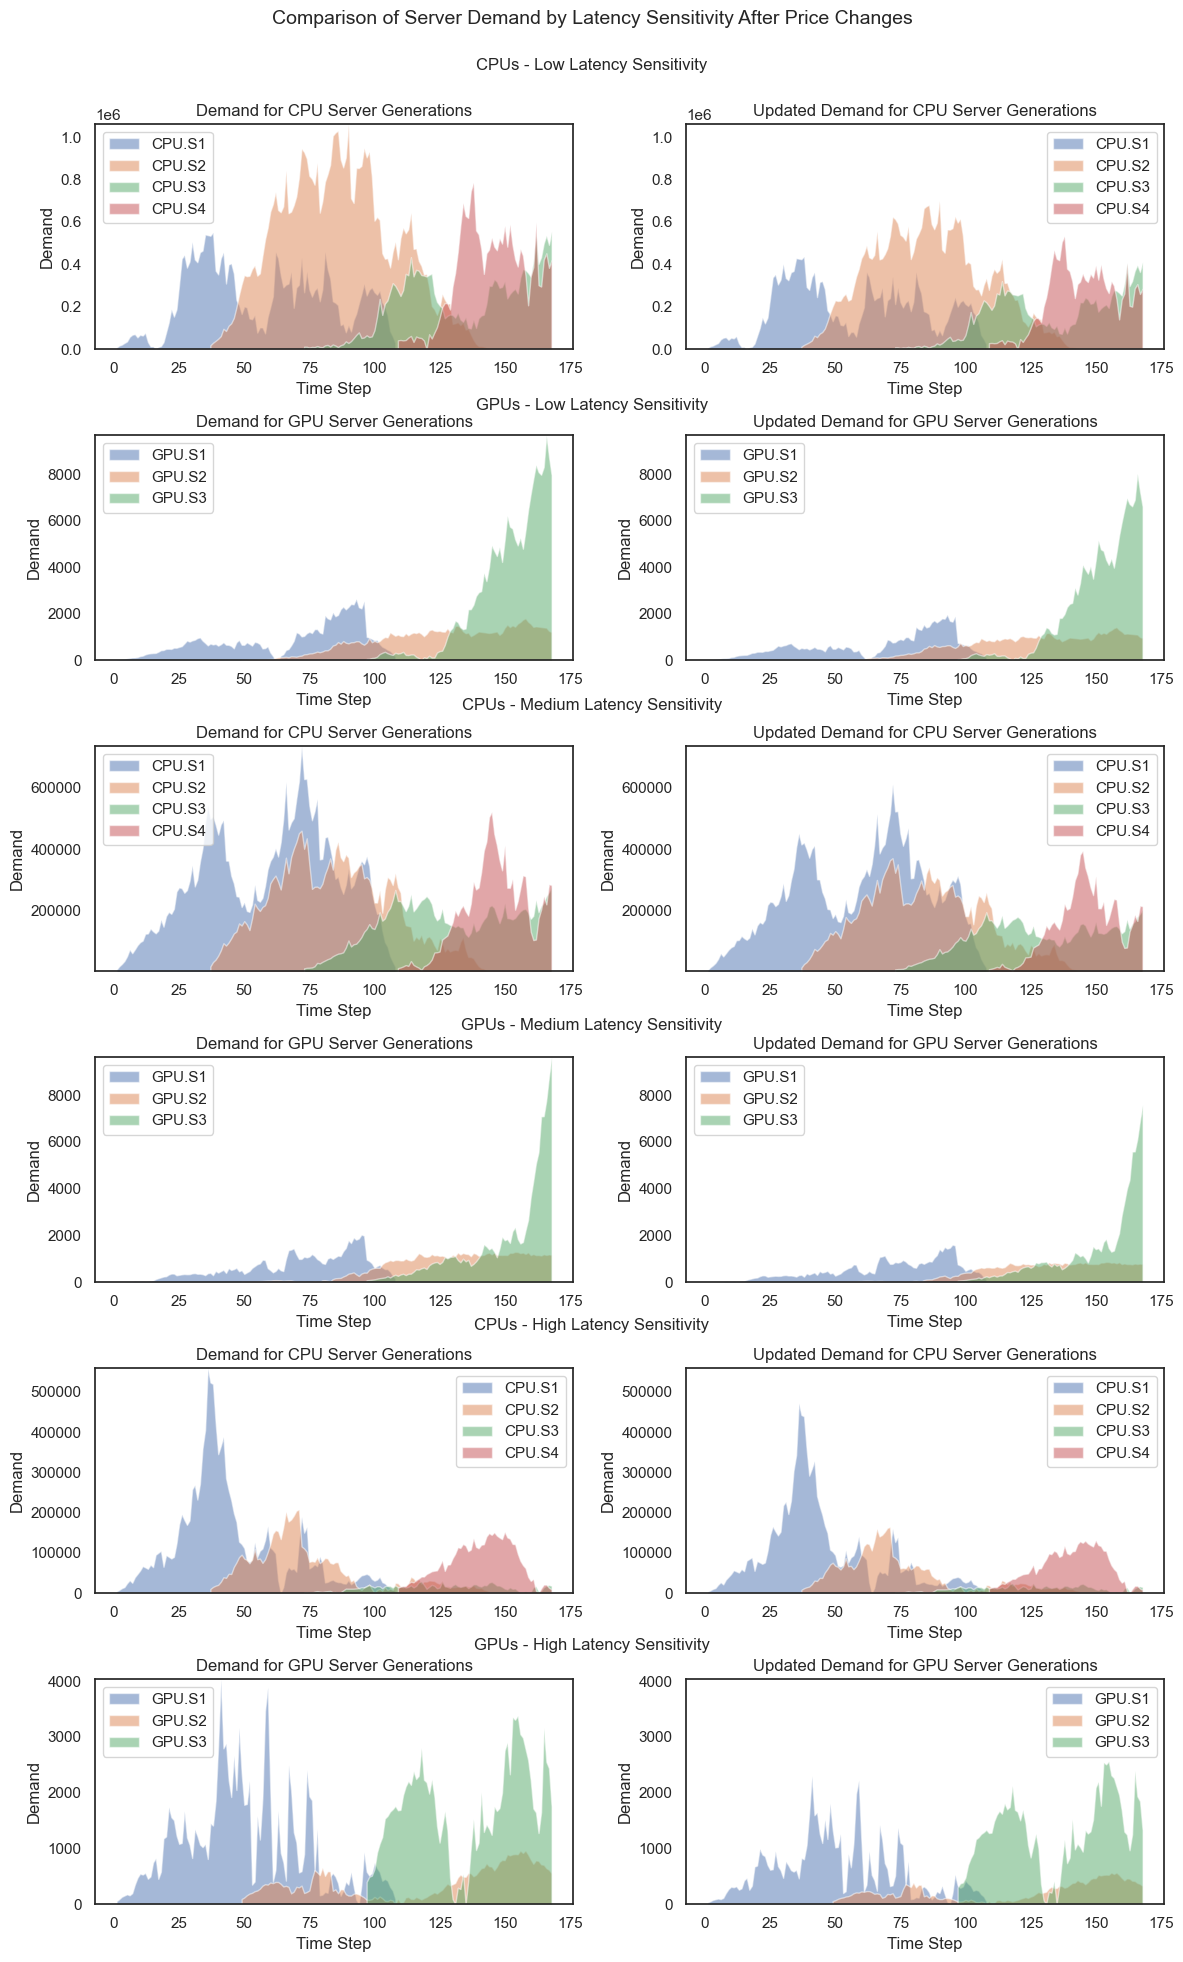

In [87]:
# Filter CPU and GPU rows
cpu_df = actual_demand[actual_demand['server_generation'].str.contains('CPU')]
cpu_df_new = new_demand[new_demand['server_generation'].str.contains('CPU')]

gpu_df = actual_demand[actual_demand['server_generation'].str.contains('GPU')]
gpu_df_new = new_demand[new_demand['server_generation'].str.contains('GPU')]

# Find global min and max for the 'low' column across all datasets
min_demand_low_cpu = min(cpu_df['low'].min(), cpu_df_new['low'].min())
max_demand_low_cpu = max(cpu_df['low'].max(), cpu_df_new['low'].max())
min_demand_medium_cpu = min(cpu_df['medium'].min(), cpu_df_new['medium'].min())
max_demand_medium_cpu = max(cpu_df['medium'].max(), cpu_df_new['medium'].max())
min_demand_high_cpu = min(cpu_df['high'].min(), cpu_df_new['high'].min())
max_demand_high_cpu = max(cpu_df['high'].max(), cpu_df_new['high'].max())

min_demand_low_gpu = min(gpu_df['low'].min(), gpu_df_new['low'].min())
max_demand_low_gpu = max(gpu_df['low'].max(), gpu_df_new['low'].max())
min_demand_medium_gpu = min(gpu_df['medium'].min(), gpu_df_new['medium'].min())
max_demand_medium_gpu = max(gpu_df['medium'].max(), gpu_df_new['medium'].max())
min_demand_high_gpu = min(gpu_df['high'].min(), gpu_df_new['high'].min())
max_demand_high_gpu = max(gpu_df['high'].max(), gpu_df_new['high'].max())

# Plot settings
sns.set(style="white")
fig, axes = plt.subplots(6, 2, figsize=(12, 20))
fig.suptitle('Comparison of Server Demand by Latency Sensitivity After Price Changes', fontsize=14)

# Plotting function for area plots
def plot_area(ax, data, latency_column, title, ymin, ymax):
    for server_type in data['server_generation'].unique():
        server_data = data[data['server_generation'] == server_type]
        ax.fill_between(server_data['time_step'], server_data[latency_column], label=server_type, alpha=0.5)
    ax.set_title(title)
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Demand')
    ax.set_ylim(ymin, ymax)  # Set the Y-axis limits to be consistent
    ax.legend()

# Plotting for Low Latency Sensitivity
## For CPU
plot_area(axes[0, 0], cpu_df, 'low', 'Demand for CPU Server Generations', min_demand_low_cpu, max_demand_low_cpu)
plot_area(axes[0, 1], cpu_df_new, 'low', 'Updated Demand for CPU Server Generations', min_demand_low_cpu, max_demand_low_cpu)

fig.text(0.5, 0.95, 'CPUs - Low Latency Sensitivity', ha='center', fontsize=12)

## For GPU
plot_area(axes[1, 0], gpu_df, 'low', 'Demand for GPU Server Generations', min_demand_low_gpu, max_demand_low_gpu)
plot_area(axes[1, 1], gpu_df_new, 'low', 'Updated Demand for GPU Server Generations', min_demand_low_gpu, max_demand_low_gpu)

fig.text(0.5, 0.78, 'GPUs - Low Latency Sensitivity', ha='center', fontsize=12)

# Plotting for Medium Latency Sensitivity
## For CPU
plot_area(axes[2, 0], cpu_df, 'medium', 'Demand for CPU Server Generations', min_demand_medium_cpu, max_demand_medium_cpu)
plot_area(axes[2, 1], cpu_df_new, 'medium', 'Updated Demand for CPU Server Generations', min_demand_medium_cpu, max_demand_medium_cpu)

fig.text(0.5, 0.63, 'CPUs - Medium Latency Sensitivity', ha='center', fontsize=12)

## For GPU
plot_area(axes[3, 0], gpu_df, 'medium', 'Demand for GPU Server Generations', min_demand_medium_gpu, max_demand_medium_gpu)
plot_area(axes[3, 1], gpu_df_new, 'medium', 'Updated Demand for GPU Server Generations', min_demand_medium_gpu, max_demand_medium_gpu)

fig.text(0.5, 0.47, 'GPUs - Medium Latency Sensitivity', ha='center', fontsize=12)

# Plotting for High Latency Sensitivity
## For CPU
plot_area(axes[4, 0], cpu_df, 'high', 'Demand for CPU Server Generations', min_demand_high_cpu, max_demand_high_cpu)
plot_area(axes[4, 1], cpu_df_new, 'high', 'Updated Demand for CPU Server Generations', min_demand_high_cpu, max_demand_high_cpu)

fig.text(0.5, 0.32, 'CPUs - High Latency Sensitivity', ha='center', fontsize=12)

## For GPU
plot_area(axes[5, 0], gpu_df, 'high', 'Demand for GPU Server Generations', min_demand_high_gpu, max_demand_high_gpu)
plot_area(axes[5, 1], gpu_df_new, 'high', 'Updated Demand for GPU Server Generations', min_demand_high_gpu, max_demand_high_gpu)

fig.text(0.5, 0.16, 'GPUs - High Latency Sensitivity', ha='center', fontsize=12)

# Adjust layout and display
plt.tight_layout(rect=[0, 0, 1, 0.96])
# Save the figure as a JPG file
plt.savefig('photo/compared_demand_analysis.jpg')
plt.show()

**Comment**: As expected, when the price increases, the demand decreases according to the law of demand.


## Load Required Data

In [ ]:
baseline_demand, datacenters, servers, selling_prices, elasticity = load_problem_data()

### Demand

In [21]:
# GET ACTUAL DEMAND
# SET THE RANDOM SEED
seed = 1741
np.random.seed(seed)
actual_demand = get_actual_demand(baseline_demand)

demand = {}
D = actual_demand.copy()
for ts in time_steps:
    for sg in server_types:
        for ls in latency_sensitivity:
            value = D[(D['time_step'] == ts) & (D['server_generation'] == sg)][ls].values
            if value.size > 0:
                demand[(ts, sg, ls)] = value[0]
            else:
                demand[(ts, sg, ls)] = 0

### Data centers

In [22]:
latency_sensitivity = list(datacenters['latency_sensitivity'].unique())
datacenters_id = list(datacenters['datacenter_id'].values)
datacenter_slots = datacenters.set_index('datacenter_id').to_dict()['slots_capacity']
datacenter_latency_map = datacenters.set_index('datacenter_id').to_dict()['latency_sensitivity']

### Servers

In [23]:
life_expectancy = 96
lifespan = np.arange(1, life_expectancy + 1)
server_types = list(servers['server_generation'].values)
purchase_cost = servers.set_index('server_generation').to_dict()['purchase_price']
server_slots = servers.set_index('server_generation').to_dict()['slots_size']
server_capacity = servers.set_index('server_generation').to_dict()['capacity']

In [24]:
renting_prices = {}
for sg in server_types:
    for ls in latency_sensitivity:
        renting_prices[(sg, ls)] = selling_prices[(selling_prices['server_generation'] == sg) & (selling_prices['latency_sensitivity'] == ls)]['selling_price'].values[0]

In [25]:
moving_cost = 1000
maintain_cost = servers.set_index('server_generation').to_dict()['average_maintenance_fee']
energy_cost = datacenters.set_index('datacenter_id').to_dict()['cost_of_energy']
energy_consumption = servers.set_index('server_generation').to_dict()['energy_consumption']
energy_prices = {(sg, dc): energy_cost[dc] * energy_consumption[sg] for sg in server_types for dc in datacenters_id}
release_time = servers.set_index('server_generation').to_dict()['release_time']
release_time = {k: eval(v) for k, v in release_time.items()}

## Problem Formulation

Let's define our notations for the Mathematical Optimisation model.

First, let's define the following sets:

**Sets**
-  $DC\quad$: Set of data center ids
-  $T\quad$: Set of timesteps
-  $LS\quad$: Latency sensitivity types
-  $SG\quad$: Server generations


**Parameters**
-  $server\_slots_{sg}\quad$: Slot of server generation $sg$
-  $server\_capacity_{sg}\quad$: Capacity of server generation $sg$
-  $data\_center\_slots_{dc}\quad$: Slot size of data center $dc$
-  $renting\_prices_{sg,ls}\quad$: Renting prices of a pair $(sg, ls)$
-  $demand\_var_{ts, sg, ls}\quad$: Demand of server generation $sg$ with latency sensitivity $ls$ at time step $ts$.

We have modified these sets and parameters in `Load Required Data`

## Decision Variables

First, we define four actions as our decision variables: the number of servers bought, moved, removed, and dismissed. The 'Hold' action is automatically applied if no dismissal action is taken for a given server.

-  $buy_{ts, sg, dc}\quad$: Number of server generation $sg$ placed at data center $dc$ at time step $ts$.
-  $move_{ts, sg, dc, life}\quad$: Number of server generation $sg$ with lifespan $life$ moved to data center $dc$ at time step $ts$.
-  $remove_{ts, sg, dc, life}\quad$: Number of server generation $sg$ with lifespan $life$ removed from data center $dc$ at time step $ts$.
-  $dismiss_{ts, sg, dc, life}\quad$: Server generation $sg$ with lifespan $life$ needs to be dismissed at data center $dc$ at time step $ts$.

Another variable is the inventory of servers at each datacenter and was updated at the end of the time-step after all actions are applied. 
- $I_{ts, sg, dc, life} \quad$: Number of server generation $sg$ with lifespan $life$ at data center $dc$ at time step $ts$.

With these initial decision variables, we can start the Mathematical Operation model:



In [27]:
import gurobipy as gp
from gurobipy import GRB
import rich

In [28]:
license_path = 'gurobi.lic'
LICENSE_DICT = load_wsl_lic(license_path)
env = gp.Env(params=LICENSE_DICT)
env.start()

model = gp.Model("Data_center_operation", env = env)
model.setParam('Seed', seed)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2546163
Academic license 2546163 - for non-commercial use only - registered to ma___@mail.dcu.ie
Set parameter Seed to value 1741


In [29]:
# Decision variables
# Buy action
buy = model.addVars(time_steps, server_types, datacenters_id, lb = 0, vtype=GRB.CONTINUOUS, name="buy")  # Number of servers bought
# Move action
move_to = model.addVars(time_steps, server_types, datacenters_id, lifespan, lb = 0, vtype=GRB.CONTINUOUS, name="move_to")  # Number of servers moved
remove_from = model.addVars(time_steps, server_types, datacenters_id, lifespan, lb = 0, vtype=GRB.CONTINUOUS, name="remove_from")  # Number of servers moved
#Dismissing servers
dismiss = model.addVars(time_steps, server_types, datacenters_id, lifespan, lb = 0, vtype=GRB.CONTINUOUS, name="dismiss")  # Number of servers moved

# Decision variables to track server lifespan in inventory
I = model.addVars(range(start_ts, end_ts + 1), server_types, datacenters_id, lifespan, lb = 0, vtype=GRB.CONTINUOUS, name="inventory") #  Inventory begins before time step = 1

## Constraints

**Set Initial Inventory:**
\begin{align}
    I_{0, sg, dc, life} &= 0 &\quad \forall \ sg \in SG, \ dc \in DC, \ life \in lifespan
\end{align}

**1. Buying Constraints:**
\begin{align}
    I_{ts, sg, dc, 1} &= 
    \begin{cases}
        buy_{ts, sg, dc} & \text{if } t \in release\_time_{sg} \\
        0 & \text{if } t \notin release\_time_{sg}
    \end{cases}
\end{align}

**2. Dismiss Servers:**
\begin{align}
    dismiss_{ts, sg, dc, life} &\leq I_{ts-1, sg, dc, life-1} \\
    dismiss_{ts, sg, dc, 1} = 0 &\quad \forall \ ts, sg, dc \\
\end{align}


**3.1 Remove and Move Constraints:**
\begin{align}
    remove\_from_{ts, sg, dc, life} &\leq I_{ts-1, sg, dc, life-1}
    &\quad \forall \ ts \in T, sg \in SG, dc \in DC, life \in [2, life\_expectancy]
\end{align}


\begin{align}
    remove\_from_{ts, sg, dc, 1} &= 0 &\quad \forall \ ts, sg, dc \\
    move\_to_{ts, sg, dc, 1} &= 0 &\quad \forall \ ts, sg, dc
\end{align}

**3.2 Balance Move-To and Remove-From:**
\begin{align}
    \sum_{\text{dc} \in \text{datacenters}} \text{move\_to}_{ts, sg, dc, life} = \sum_{\text{dc} \in \text{datacenters}} \text{remove\_from}_{ts, sg, dc, life} \\
    &\quad \forall \ ts \in T, sg \in SG, life \in [2, life\_expectancy]
\end{align}

**4. Updated Inventory:**
\begin{align}
    I_{ts, sg, dc, life} &= I_{ts-1, sg, dc, life-1} + move\_to_{ts, sg, dc, life} - remove\_from_{ts, sg, dc, life} - dismiss_{ts, sg, dc, life} \\
    &\forall \ ts \in T, sg \in SG, dc \in DC, life \in lifespan
\end{align}

**5. Slot Constraint:**
\begin{align}
    \sum_{sg \in SG, life \in lifespan} I_{ts, sg, dc, life} * server\_slots_{sg} &\leq data\_center\_slots_{dc} \\
    &\forall \ ts \in T, dc \in DC
\end{align}

Specifically, the capacity $Z^{f}_{sg, ls}$ is equal to the sum of the capacities of all servers of generation $sg$ deployed across all data-centers with latency sensitivity $ls$ adjusted by the failure rate $f$ as follows:

$$
Z^{f}_{ts, sg, ls} = (1 - f) \times Z_{ts, sg, ls}
$$

**6. Min(Zf, Demand):**
\begin{align}
    min\_var_{ts, sg, ls} \leq Z^{f}_{ts, sg, ls} \\
    min\_var_{ts, sg, ls} \leq demand_{ts, sg, ls}
    &\forall \ ts \in T, dc \in DC
\end{align}

In [30]:
# Auxiliary variable for min(I, demand)
min_var = model.addVars(time_steps, server_types, latency_sensitivity, vtype=GRB.CONTINUOUS,lb = 0, name="min_var")
Zf_var = model.addVars(time_steps, server_types, latency_sensitivity, vtype=GRB.CONTINUOUS,lb = 0, name="Zf_var")

# Objective
R_recorded = [0] * (len(time_steps) + 1)
C_recorded = [0] * (len(time_steps) + 1)
P_recorded = [0] * (len(time_steps) + 1)
total_profit = gp.LinExpr()

In [31]:
# Initialise inventory
for sg in server_types:
    for dc in datacenters_id:
        for life in lifespan:
            model.addConstr(I[start_ts, sg, dc, life] == 0,
                            name=f"set_up_initial_inventory_{start_ts}_{sg}_{dc}_life_{life}")

In [32]:
for ts in time_steps:
    # 1. Buying constraint respecting the release window
    for sg in server_types:
        for dc in datacenters_id:
            # Only allow purchases during the server's release time window
            if (ts >= release_time[sg][0]) and (ts <= release_time[sg][1]):
                model.addConstr(I[ts, sg, dc, 1] == buy[ts, sg, dc], name=f"buy_constraint_{ts}_{sg}_{dc}")
            else:
                # Prevent buying servers outside the release window
                model.addConstr(buy[ts, sg, dc] == 0, name=f"no_buy_{ts}_{sg}_{dc}")
                model.addConstr(I[ts, sg, dc, 1] == 0, name=f"no_buy_{ts}_{sg}_{dc}")

    # 2. Dismiss servers constraint
    for sg in server_types:
        for dc in datacenters_id:
            for life in range(2, life_expectancy + 1):
                model.addConstr(dismiss[ts, sg, dc, life] <= I[ts - 1, sg, dc, life - 1], name=f"dismiss_constraint_{ts}_{sg}_{dc}_life_{life}")
            # No dismiss servers right after buying that servers
            model.addConstr(dismiss[ts, sg, dc, 1] == 0, name=f"no_dismiss_at_beginning_{start_ts}_{sg}_{dc}")

    # 3.1 Remove and move constraint: available resources
    for sg in server_types:
        for dc in datacenters_id:
            for life in range(2, life_expectancy + 1):
                model.addConstr(remove_from[ts, sg, dc, life] <= I[ts - 1, sg, dc, life - 1] - dismiss[ts, sg, dc, life], # Dismiss before moving
                name = f"remove_constraint_availabel_resource_{ts - 1}_{sg}_{dc}_{life}")
            # No remove or move servers right after buying that servers
            model.addConstr(remove_from[ts, sg, dc, 1] == 0, name=f"no_remove_at_beginning_{start_ts}_{sg}_{dc}")
            model.addConstr(move_to[ts, sg, dc, 1] == 0, name=f"no_move_at_beginning_{start_ts}_{sg}_{dc}")


    # 3.2 Balance move_to and remove_from
    for sg in server_types:
        for life in range(2, life_expectancy + 1):
            model.addConstr(gp.quicksum(move_to[ts, sg, dc, life] for dc in datacenters_id)  == gp.quicksum(remove_from[ts, sg, dc, life] for dc in datacenters_id),
                                name=f"balance_move_to_remove_from_{ts}_{sg}_life_{life}")



    # 4. Update inventory after moving servers
    for sg in server_types:
            for dc in datacenters_id:
                for life in range(2, life_expectancy + 1):
                    model.addConstr(I[ts, sg, dc, life] == I[ts - 1, sg, dc, life - 1] + move_to[ts, sg, dc, life] - remove_from[ts, sg, dc, life] - dismiss[ts, sg, dc, life],
                            name=f"update_inventory_after_all_actions_{ts}_{sg}_{dc}_life_{life}")



    # 5. Constraint: Slot capacity of each datacenter
    for dc in datacenters_id:
        model.addConstr(
            gp.quicksum(I[ts, sg, dc, life] * server_slots[sg] for sg in server_types for life in lifespan) <= datacenter_slots[dc],
            name=f"slot_capacity_{ts}_{dc}"
        )


    # 6. Add constraint to enforce min_var[ts, sg, ls] = min(I[ts, sg, ls], demand[ts, sg, ls])
    for sg in server_types:
        for ls in latency_sensitivity:
            # Total inventory across all lifespans
            total_inventory = gp.quicksum(I[ts, sg, dc, life] for dc in datacenters_id if datacenter_latency_map[dc] == ls for life in lifespan)
            capacity = total_inventory * server_capacity[sg]
            model.addConstr(Zf_var[ts, sg, ls] == adjust_capacity_by_failure_rate(capacity), name=f"custom_capacity_{ts}_{sg}_{ls}")
            model.addConstr(min_var[ts, sg, ls] <= Zf_var.get((ts, sg, ls), 0), name=f"min_capacity_{ts}_{sg}_{ls}")
            model.addConstr(min_var[ts, sg, ls] <= demand.get((ts, sg, ls), 0), name=f"min_demand_{ts}_{sg}_{ls}")

## Objective

The objective is to maximize the total profit in 168 time steps.
\begin{align}
    Maximize \quad \sum_{ts \in T} \text{profit}_{ts}
\end{align}

**Revenue at time step ts**
\begin{align}
    \text{revenue}_{ts} &= \sum_{sg \in SG} \sum_{ls \in LS} \text{min\_var}_{ts, sg, ls} \times \text{renting\_prices}(sg, ls)
\end{align}

**Buying Cost at time step ts**
\begin{align}
    \text{buy\_cost}_{ts} &= \sum_{sg \in SG} \sum_{dc \in DC} \text{purchase\_cost}_{sg} \times \text{buy}_{ts, sg, dc}
\end{align}

**Energy Cost at time step ts**
\begin{align}
    \text{energy\_cost}_{ts} &= \sum_{sg \in SG} \sum_{dc \in DC} \text{energy\_prices}_{sg, dc} \times \sum_{life \in lifespan} I_{ts, sg, dc, life}
\end{align}

**Maintenance Cost at time step ts**
\begin{align}
    \text{maintenance\_cost}_{ts} &= \sum_{sg \in SG} \sum_{dc \in DC} \sum_{life \in lifespan} \text{get\_maintenance\_cost}(\text{maintain\_cost}_{sg, life}) \times I_{ts, sg, dc, life}
\end{align}

**Moving Cost at time step ts**
\begin{align}
    \text{moving\_cost}_{ts} &= \text{moving\_cost} \times \sum_{sg \in SG} \sum_{dc \in DC} \sum_{life=2}^{\text{life\_expectancy}} \text{move\_to}_{ts, sg, dc, life}
\end{align}

**Total Cost at time step ts**
\begin{align}
    \text{total\_cost}_{ts} &= \text{buy\_cost}_{ts} + \text{energy\_cost}_{ts} + \text{maintenance\_cost}_{ts} + \text{moving\_cost}_{ts}
\end{align}

**Profit at time step ts**
\begin{align}
    \text{profit}_{ts} &= \text{revenue}_{ts} - \text{total\_cost}_{ts}
\end{align}

**Total Profit accumulated over all time steps**
\begin{align}
    \text{total\_profit} &= \sum_{ts \in T} \text{profit}_{ts}
\end{align}

In [33]:
for ts in time_steps:
  # Revenue at time step ts
  revenue_ts = gp.quicksum(
      min_var[ts, sg, ls] * renting_prices.get((sg, ls), 0)
      for sg in server_types for ls in latency_sensitivity
  )

  R_recorded[ts] = revenue_ts

  # Cost at time step ts
  buy_cost_ts = gp.quicksum(purchase_cost[sg] * buy[ts, sg, dc] for sg in server_types for dc in datacenters_id)
  energy_cost_ts = gp.quicksum(energy_prices[sg, dc] * gp.quicksum(I[ts, sg, dc, life] for life in lifespan) for sg in server_types for dc in datacenters_id)

  # Maintenance cost at time step ts:

  maintenance_cost_ts = gp.quicksum(
      get_maintenance_cost(maintain_cost[sg], life) * I[ts, sg, dc, life]
      for sg in server_types for dc in datacenters_id for life in lifespan
  )

  moving_cost_ts = moving_cost * gp.quicksum(move_to[ts, sg, dc, life] for life in range(2, life_expectancy + 1) for sg in server_types for dc in datacenters_id)


  # Total cost at time step ts
  total_cost_ts = buy_cost_ts + energy_cost_ts + maintenance_cost_ts + moving_cost_ts
  C_recorded[ts] = total_cost_ts

  # Profit at time step t
  profit_ts = revenue_ts - total_cost_ts
  P_recorded[ts] = profit_ts

  # Accumulate the profit
  total_profit += profit_ts

In [34]:
model.setObjective(total_profit, GRB.MAXIMIZE)
model.update()

In [35]:
# Gurobi optimization settings to improve speed and performance
opt = {
    "Presolve": 2,       # Aggressive presolve
    "PreSparsify": 2,    # Remove redundant constraints
    "Aggregate": 2,      # Aggressive aggregation
    "OutputFlag": 1,     # Enable output to track progress
}

# Set model parameters
model.setParam('Presolve', opt["Presolve"])
model.setParam('PreSparsify', opt["PreSparsify"])
model.setParam('Aggregate', opt["Aggregate"])
model.setParam('OutputFlag', opt["OutputFlag"])

Set parameter Presolve to value 2
Set parameter PreSparsify to value 2
Set parameter Aggregate to value 2


We can now tell Gurobi that the model is complete and it can solve the problem.

In [36]:
# Optimize model
model.optimize()

rich.print(f"Profit: {total_profit.getValue():0,.2f}")

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[x86] - Darwin 22.5.0 22F66)

CPU model: Intel(R) Core(TM) i7-1060NG7 CPU @ 1.20GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2546163 - for non-commercial use only - registered to ma___@mail.dcu.ie
Optimize a model with 1488000 rows, 1820784 columns and 6306048 nonzeros
Model fingerprint: 0x79d725d2
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [1e+01, 2e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 1e+06]
Presolve removed 1154916 rows and 1390752 columns (presolve time = 5s) ...
Presolve removed 1282809 rows and 1390930 columns
Presolve time: 10.45s
Presolved: 205191 rows, 429854 columns, 1907373 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Elapsed ordering time = 5s
Elapsed ordering time = 10s
Ordering time: 10.84s

Barrier statistics:
 AA' NZ     : 2.054e+06
 Factor NZ  : 1.187e+07 (r

Profit: 1,986,689,110.38

## Post Processing

In [43]:
action_dict = {
        'server_generation': [],
        'datacenter_id': [],
        'time_step': [],
        'lifespan': [],
        'buying_servers': [],
        'remove': [],
        'move_to': [],
        'dismiss': []
    }

utilisation_dict = {
    'server_generation': [],
    'latency_sensitivity': [],
    'time_step': [],
    'capacity': [],
    'demand': [],
}

business_metric_dict = {
    'time_step': [],
    'revenue': [],
    'cost': [],
    'profit': []
}

if model.status == GRB.OPTIMAL:
    for ts in tqdm(time_steps):
        business_metric_dict['time_step'].append(ts)
        revenue_at_ts = float(R_recorded[ts].getValue())
        cost_at_ts = float(C_recorded[ts].getValue())
        profit_at_ts = float(P_recorded[ts].getValue())

        business_metric_dict['revenue'].append(revenue_at_ts)
        business_metric_dict['cost'].append(cost_at_ts)
        business_metric_dict['profit'].append(profit_at_ts)

        # Buying servers
        for sg in server_types:
            for dc in datacenters_id:
                bought_qty = buy[ts, sg, dc].x
                action_dict['server_generation'].append(sg)
                action_dict['datacenter_id'].append(dc)
                action_dict['time_step'].append(ts)
                action_dict['lifespan'].append(1)
                action_dict['buying_servers'].append(bought_qty)
                action_dict['remove'].append(0)
                action_dict['move_to'].append(0)
                action_dict['dismiss'].append(0)
            for ls in latency_sensitivity:
                capacity = Zf_var[ts, sg, ls].x
                demand_ts = demand.get((ts, sg, ls), 0)
                utilisation_dict['server_generation'].append(sg)
                utilisation_dict['latency_sensitivity'].append(ls)
                utilisation_dict['time_step'].append(ts)
                utilisation_dict['capacity'].append(capacity)
                utilisation_dict['demand'].append(demand_ts)


        # Moving and dismissing servers
        for sg in server_types:
            for dc in datacenters_id:
                for life in range(2, life_expectancy + 1):
                    remove_qty = remove_from[ts, sg, dc, life].x
                    moveto_qty = move_to[ts, sg, dc, life].x
                    dismiss_qty = dismiss[ts, sg, dc, life].x

                    action_dict['server_generation'].append(sg)
                    action_dict['datacenter_id'].append(dc)
                    action_dict['time_step'].append(ts)
                    action_dict['lifespan'].append(life)
                    action_dict['buying_servers'].append(0)
                    action_dict['remove'].append(remove_qty)
                    action_dict['move_to'].append(moveto_qty)
                    action_dict['dismiss'].append(dismiss_qty)

    action_df = pd.DataFrame(action_dict)
    action_df.to_csv(f'result/all_action_df_{seed}.csv', index=False)

    utilisation_df = pd.DataFrame(utilisation_dict)
    utilisation_df.to_csv(f'result/utilisation_df_{seed}.csv', index=False)  

    business_metric = pd.DataFrame(business_metric_dict)
    business_metric.to_csv(f'result/business_metric_{seed}.csv', index=False)
    
    print("All actions have been saved!")

100%|██████████| 168/168 [00:10<00:00, 16.12it/s]


All actions have been saved!


In [38]:
action_df

,server_generation,datacenter_id,time_step,lifespan,buying_servers,remove,move_to,dismiss
0,CPU.S1,DC1,1,1,143.799133,0.0,0.0,0.0
1,CPU.S1,DC2,1,1,164.571327,0.0,0.0,0.0
2,CPU.S1,DC3,1,1,76.648854,0.0,0.0,0.0
3,CPU.S1,DC4,1,1,0.000000,0.0,0.0,0.0
4,CPU.S2,DC1,1,1,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
451579,GPU.S3,DC4,168,92,0.000000,0.0,0.0,0.0
451580,GPU.S3,DC4,168,93,0.000000,0.0,0.0,0.0
451581,GPU.S3,DC4,168,94,0.000000,0.0,0.0,0.0
451582,GPU.S3,DC4,168,95,0.000000,0.0,0.0,0.0


In [39]:
utilisation_df

,server_generation,latency_sensitivity,time_step,capacity,demand
0,CPU.S1,low,1,7937.000000,7937
1,CPU.S1,medium,1,9235.000000,9235
2,CPU.S1,high,1,4346.000000,4346
3,CPU.S2,low,1,0.000000,0
4,CPU.S2,medium,1,0.000000,0
...,...,...,...,...,...
3523,GPU.S2,medium,168,1166.000000,1166
3524,GPU.S2,high,168,555.000000,555
3525,GPU.S3,low,168,0.000000,7966
3526,GPU.S3,medium,168,8422.302585,9608


### Visualise Utilisation

In [27]:
# utilisation_df = pd.read_csv("result/utilisation_df_1741.csv")

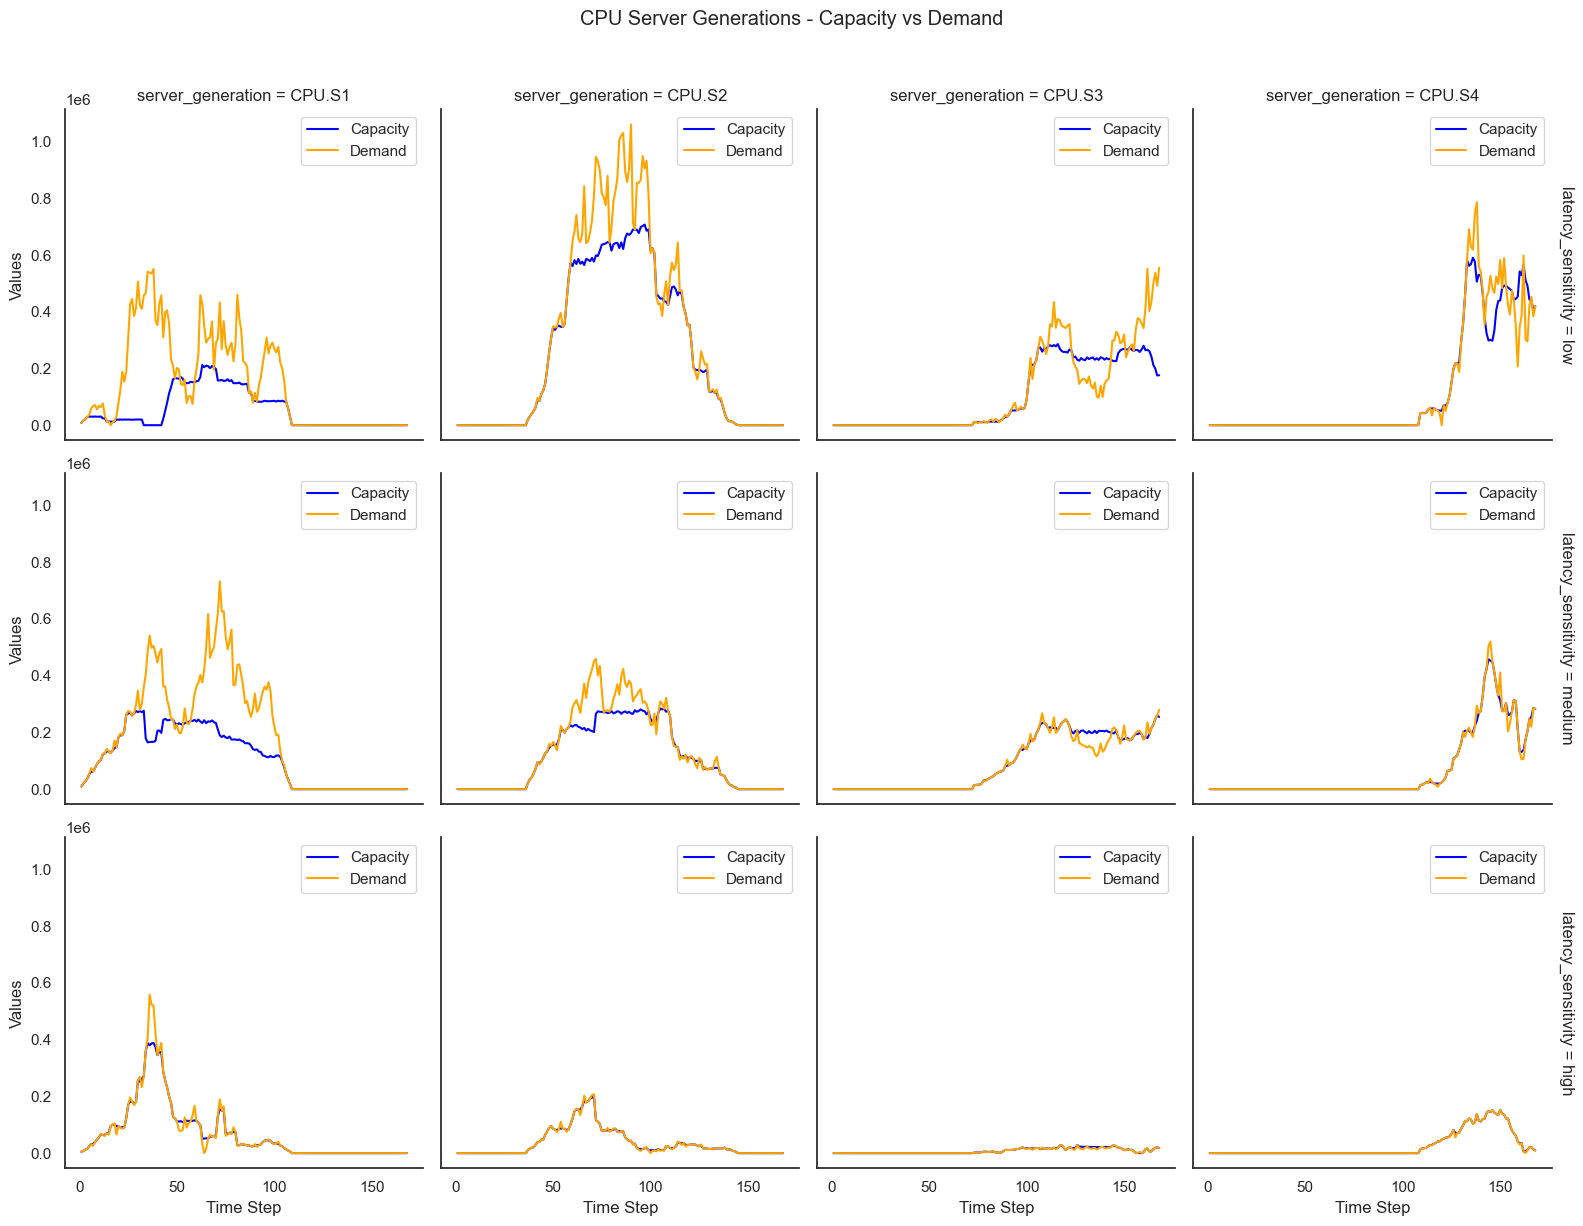

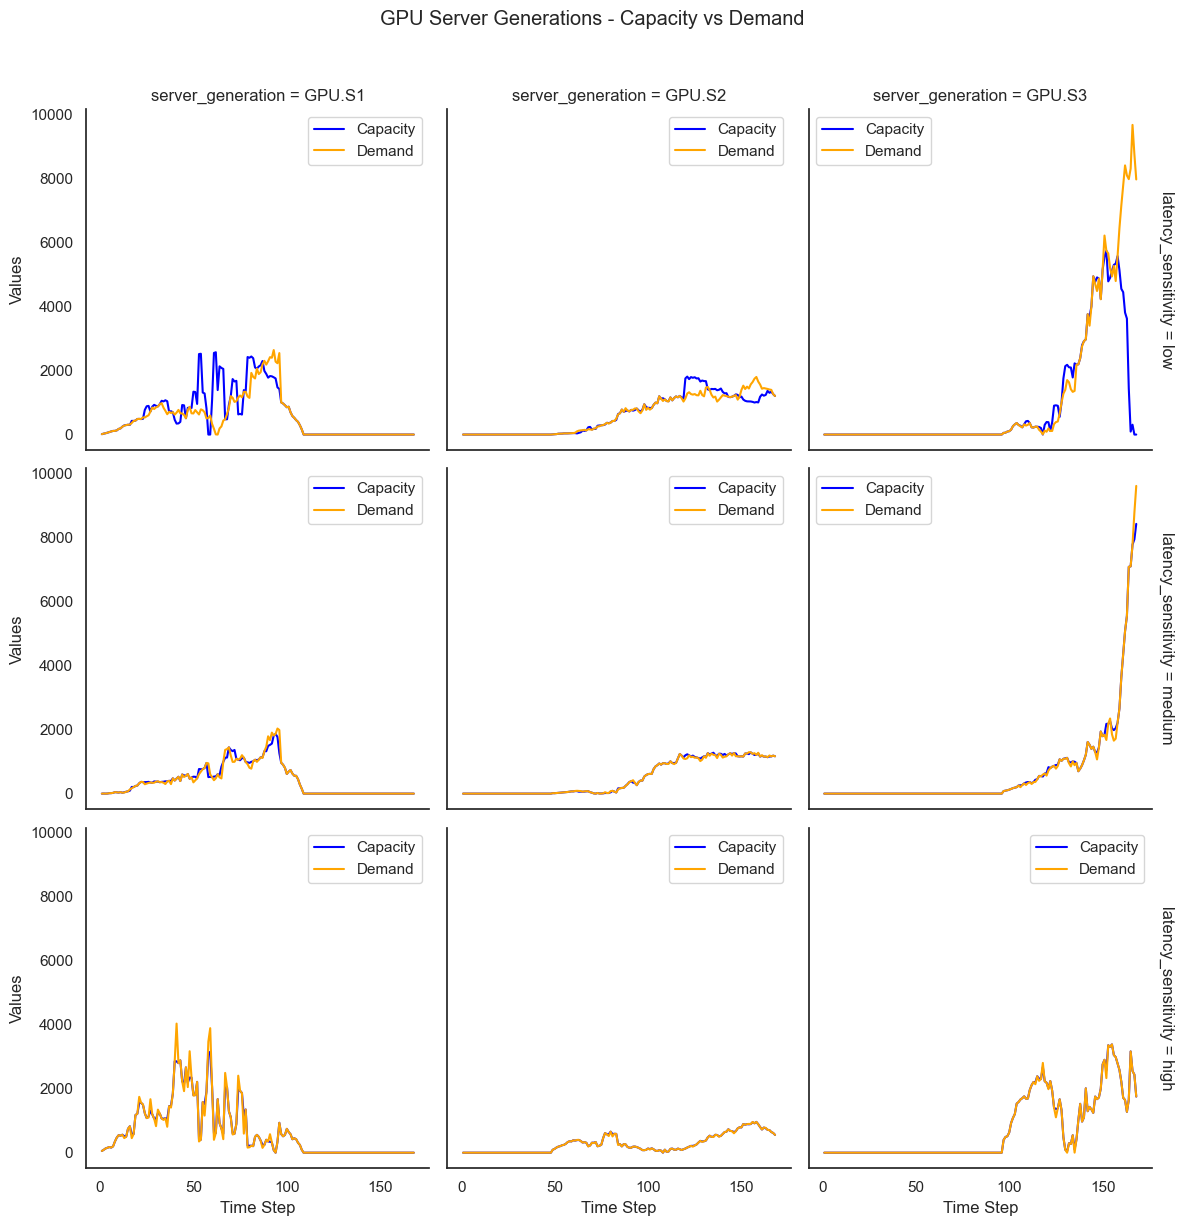

In [29]:
# Add a new column to distinguish between CPU and GPU
utilisation_df['server_type'] = utilisation_df['server_generation'].apply(lambda x: 'CPU' if 'CPU' in x else 'GPU')

# Plot for CPU group
cpu_df = utilisation_df[utilisation_df['server_type'] == 'CPU']
g_cpu = sns.FacetGrid(cpu_df, col="server_generation", row="latency_sensitivity", margin_titles=True, height=4)
g_cpu.map(plt.plot, "time_step", "capacity", label="Capacity", color="blue")
g_cpu.map(plt.plot, "time_step", "demand", label="Demand", color="orange")

# Add legends for CPU plots
for ax in g_cpu.axes.flat:
    ax.legend()

g_cpu.set_axis_labels("Time Step", "Values")
g_cpu.fig.suptitle('CPU Server Generations - Capacity vs Demand', y=1.02)
plt.tight_layout()
plt.savefig("photo/utilisation_cpu.jpg")
plt.show()

# Plot for GPU group
gpu_df = utilisation_df[utilisation_df['server_type'] == 'GPU']
g_gpu = sns.FacetGrid(gpu_df, col="server_generation", row="latency_sensitivity", margin_titles=True, height=4)
g_gpu.map(plt.plot, "time_step", "capacity", label="Capacity", color="blue")
g_gpu.map(plt.plot, "time_step", "demand", label="Demand", color="orange")

# Add legends for GPU plots
for ax in g_gpu.axes.flat:
    ax.legend()

g_gpu.set_axis_labels("Time Step", "Values")
g_gpu.fig.suptitle('GPU Server Generations - Capacity vs Demand', y=1.02)
plt.tight_layout()
plt.savefig("photo/utilisation_gpu.jpg")
plt.show()


### Visualise Business Metric

In [31]:
business_metric = pd.read_csv("result/business_metric_1741.csv")

In [32]:
business_metric

,time_step,revenue,cost,profit
0,1,4.457950e+05,7.030118e+06,-6.584323e+06
1,2,8.812550e+05,7.558309e+06,-6.677054e+06
2,3,1.242220e+06,5.885794e+06,-4.643574e+06
3,4,1.608760e+06,7.140491e+06,-5.531731e+06
4,5,2.173584e+06,8.744961e+06,-6.571377e+06
...,...,...,...,...
163,164,4.453002e+07,1.225969e+07,3.227033e+07
164,165,4.832054e+07,1.280706e+07,3.551348e+07
165,166,4.883679e+07,1.230016e+07,3.653663e+07
166,167,4.834852e+07,1.263192e+07,3.571660e+07


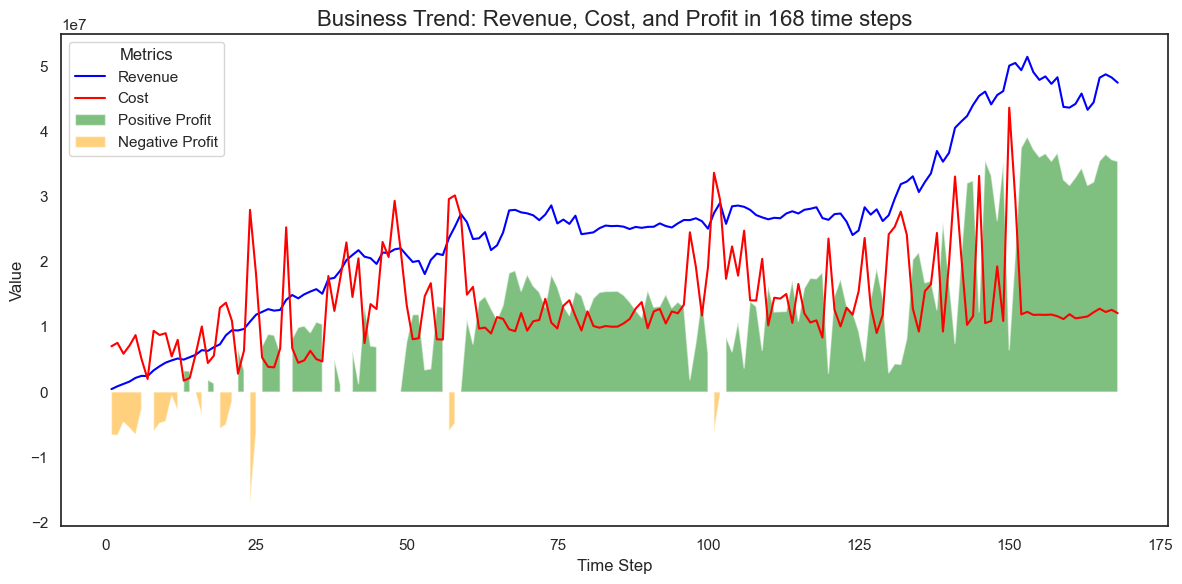

In [33]:
# Create a figure
plt.figure(figsize=(12, 6))

# Plot revenue and cost as lines
sns.lineplot(x="time_step", y="revenue", data=business_metric, label="Revenue", color="blue")
sns.lineplot(x="time_step", y="cost", data=business_metric, label="Cost", color="red")

# Area plot for profit, separate positive and negative areas
plt.fill_between(business_metric['time_step'], business_metric['profit'], where=(business_metric['profit'] > 0), facecolor='green', alpha=0.5, label="Positive Profit")
plt.fill_between(business_metric['time_step'], business_metric['profit'], where=(business_metric['profit'] <= 0), facecolor='orange', alpha=0.5, label="Negative Profit")

# Set plot labels and title
plt.title("Business Trend: Revenue, Cost, and Profit in 168 time steps", fontsize=16)
plt.xlabel("Time Step", fontsize=12)
plt.ylabel("Value", fontsize=12)

# Add a legend
plt.legend(title="Metrics")

# Show the plot
plt.tight_layout()
plt.savefig("photo/business_trend.jpg")
plt.show()


# Extra

## Senario Analysis

An important requirements in many MO problems is scenario analysis, also known as what-if analysis. Generally speaking, in what-if analysis, we're interested in understanding how the solution changes under various scenarios. Consider our case here:

- How does the solution change if each server generation has a different life expectancy? In reality, servers have varying life expectancies.
- What if utilization is prioritized over profit?
- What if a new data center is added, or an existing data center is expanded?
- What if we can adjust the selling prices to increase profit?

Our model here is still a simple model. But you can imagine the value that the scenario analysis can provide. It can enable you to answer many questions by creating and comparing different scenarios and evaluating their outcomes, so that you can assess their impacts on the business goals.